Niniejszy notatnik dotyczy danych z kwestionariusza — ocen obrazów w czterech kategoriach oraz analizy wpływu metryczki na te oceny.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import statsmodels.formula.api as smf

# Wczytanie danych

In [2]:
df = pd.read_csv("MGR/Kwestionariusz_ocena.csv")
df.head()

,ID,plec,wiek,miejsce_zamieszaknia,znajomosc_sztuki,sytuacja_materialna,grupa,obraz1_gust,obraz1_przeslanie,obraz1_piekno,...,obraz6_wartosc,obraz7_gust,obraz7_przeslanie,obraz7_piekno,obraz7_wartosc,obraz8_gust,obraz8_przeslanie,obraz8_piekno,obraz8_wartosc,uwagi
0,1.0,m,23.0,mieszkanie_wynajmowane,ograniczona,2.0,k,4.0,3.0,4.0,...,3.0,5.0,3.0,4.0,4.0,4.0,2.0,4.0,3.0,OUTED be NICHT WORK
1,2.0,m,23.0,mieszkanie_wynajmowane,brak,2.0,k,3.0,1.0,4.0,...,2.0,2.0,1.0,3.0,4.0,4.0,4.0,5.0,5.0,NaN
2,3.0,k,24.0,mieszkanie_wynajmowane,ograniczona,2.0,k,4.0,3.0,4.0,...,2.0,5.0,4.0,5.0,3.0,4.0,4.0,4.0,4.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,k,24.0,mieszkanie_wlasne,ograniczona,3.0,k,3.0,1.0,3.0,...,2.0,4.0,2.0,4.0,3.0,5.0,4.0,4.0,4.0,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    26 non-null     float64
 1   plec                  26 non-null     object 
 2   wiek                  26 non-null     float64
 3   miejsce_zamieszaknia  26 non-null     object 
 4   znajomosc_sztuki      26 non-null     object 
 5   sytuacja_materialna   26 non-null     float64
 6   grupa                 26 non-null     object 
 7   obraz1_gust           26 non-null     float64
 8   obraz1_przeslanie     26 non-null     float64
 9   obraz1_piekno         26 non-null     float64
 10  obraz1_wartosc        26 non-null     float64
 11  obraz2_gust           26 non-null     float64
 12  obraz2_przeslanie     26 non-null     float64
 13  obraz2_piekno         26 non-null     float64
 14  obraz2_wartosc        26 non-null     float64
 15  obraz3_gust           26 

# Czyszczenie danych

In [4]:
missing = df.isnull().sum()
missing[missing > 0]

ID                       5
plec                     5
wiek                     5
miejsce_zamieszaknia     5
znajomosc_sztuki         5
sytuacja_materialna      5
grupa                    5
obraz1_gust              5
obraz1_przeslanie        5
obraz1_piekno            5
obraz1_wartosc           5
obraz2_gust              5
obraz2_przeslanie        5
obraz2_piekno            5
obraz2_wartosc           5
obraz3_gust              5
obraz3_przeslanie        5
obraz3_piekno            5
obraz3_wartosc           5
obraz4_gust              5
obraz4_przeslanie        5
obraz4_piekno            5
obraz4_wartosc           5
obraz5_gust              5
obraz5_przeslanie        5
obraz5_piekno            5
obraz5_wartosc           5
obraz6_gust              5
obraz6_przeslanie        5
obraz6_piekno            5
obraz6_wartosc           5
obraz7_gust              5
obraz7_przeslanie        5
obraz7_piekno            5
obraz7_wartosc           5
obraz8_gust              5
obraz8_przeslanie        5
o

### usunięcie braków
Usuniemy wiersze z nullami (te gdzie nie miałyśmy ankiet) oraz te, które nie weszły do badania (1 i 29)

In [5]:
df = df.dropna(how='all')
df = df[df.ID != 1]
df = df[df.ID != 29]

missing = df.isnull().sum()
missing[missing > 0]

uwagi    11
dtype: int64

Braki mamy teraz tylko w uwagach, reszta wygląda w porządku

### Przekształcenie danych do formatu long

teraz mamy do czynienia z dość szerokimi danymi - łatwiej będzie je analizować mając osobne rekordy w formacie long

In [6]:
df #wide format

,ID,plec,wiek,miejsce_zamieszaknia,znajomosc_sztuki,sytuacja_materialna,grupa,obraz1_gust,obraz1_przeslanie,obraz1_piekno,...,obraz6_wartosc,obraz7_gust,obraz7_przeslanie,obraz7_piekno,obraz7_wartosc,obraz8_gust,obraz8_przeslanie,obraz8_piekno,obraz8_wartosc,uwagi
1,2.0,m,23.0,mieszkanie_wynajmowane,brak,2.0,k,3.0,1.0,4.0,...,2.0,2.0,1.0,3.0,4.0,4.0,4.0,5.0,5.0,NaN
2,3.0,k,24.0,mieszkanie_wynajmowane,ograniczona,2.0,k,4.0,3.0,4.0,...,2.0,5.0,4.0,5.0,3.0,4.0,4.0,4.0,4.0,NaN
4,5.0,k,24.0,mieszkanie_wlasne,ograniczona,3.0,k,3.0,1.0,3.0,...,2.0,4.0,2.0,4.0,3.0,5.0,4.0,4.0,4.0,NaN
5,6.0,m,24.0,dom_rodzinny,ograniczona,2.0,k,2.0,1.0,3.0,...,2.0,3.0,1.0,3.0,2.0,4.0,3.0,4.0,3.0,NaN
6,7.0,k,24.0,mieszkanie_wynajmowane,ograniczona,2.0,k,4.0,3.0,4.0,...,2.0,4.0,3.0,4.0,2.0,5.0,4.0,5.0,3.0,NaN
7,8.0,k,24.0,akademik,hobbystyczna,2.0,e,3.0,1.0,3.0,...,2.0,4.0,1.0,5.0,3.0,3.0,1.0,3.0,2.0,trochę się oczy rozjechały w trakcie + trochę ...
8,9.0,m,24.0,mieszkanie_wynajmowane,hobbystyczna,2.0,k,4.0,3.0,4.0,...,2.0,5.0,4.0,5.0,3.0,5.0,2.0,4.0,4.0,NaN
9,10.0,m,23.0,mieszkanie_wynajmowane,ograniczona,2.0,k,3.0,1.0,3.0,...,5.0,5.0,2.0,5.0,4.0,2.0,1.0,4.0,2.0,R oko sus + skacze wzrokiem mega
10,11.0,k,22.0,dom_rodzinny,ograniczona,2.0,e,4.0,2.0,4.0,...,3.0,5.0,3.0,5.0,4.0,3.0,1.0,3.0,1.0,NaN
11,12.0,m,22.0,dom_rodzinny,ograniczona,2.0,e,4.0,2.0,4.0,...,2.0,4.0,3.0,4.0,3.0,5.0,4.0,4.0,1.0,NaN


In [7]:
#tworzenie long format

#lista obrazów
obrazy = list(range(1, 9))

#mapa typu podpisu
mapa_podpisow = {
    1: "nieznane_AI",
    2: "fałszywe_ludzkie",
    3: "nieznane_ludzkie",
    4: "prawdziwe_ludzkie",
    5: "fałszywe_AI",
    6: "nieznane_ludzkie",
    7: "nieznane_AI",
    8: "prawdziwe_AI"
}

long_data = []

for i, row in df.iterrows():
    for nr in obrazy:
        long_data.append({
            'ID': row['ID'],
            'grupa': row['grupa'],
            'plec': row['plec'],
            'wiek': row['wiek'],
            'miejsce_zamieszkania': row['miejsce_zamieszaknia'],
            'znajomosc_sztuki': row['znajomosc_sztuki'],
            'sytuacja_materialna': row['sytuacja_materialna'],
            'numer_obrazu': nr,
            'gust': row[f'obraz{nr}_gust'],
            'przeslanie': row[f'obraz{nr}_przeslanie'],
            'piekno': row[f'obraz{nr}_piekno'],
            'wartosc': row[f'obraz{nr}_wartosc'],
            'typ_podpisu': 'nieznane' if row['grupa'] == 'kontrolna' else mapa_podpisow[nr]
        })

# long_data

long_df = pd.DataFrame(long_data)

#is_nieznane - żeby potem filtrować łatwiej
long_df['czy_nieznane'] = (long_df['typ_podpisu'] == 'nieznane')

long_df.head()

,ID,grupa,plec,wiek,miejsce_zamieszkania,znajomosc_sztuki,sytuacja_materialna,numer_obrazu,gust,przeslanie,piekno,wartosc,typ_podpisu,czy_nieznane
0,2.0,k,m,23.0,mieszkanie_wynajmowane,brak,2.0,1,3.0,1.0,4.0,1.0,nieznane_AI,False
1,2.0,k,m,23.0,mieszkanie_wynajmowane,brak,2.0,2,4.0,1.0,4.0,2.0,fałszywe_ludzkie,False
2,2.0,k,m,23.0,mieszkanie_wynajmowane,brak,2.0,3,1.0,3.0,1.0,2.0,nieznane_ludzkie,False
3,2.0,k,m,23.0,mieszkanie_wynajmowane,brak,2.0,4,4.0,2.0,4.0,3.0,prawdziwe_ludzkie,False
4,2.0,k,m,23.0,mieszkanie_wynajmowane,brak,2.0,5,5.0,1.0,5.0,3.0,fałszywe_AI,False


In [8]:
long_df.sample(5)

,ID,grupa,plec,wiek,miejsce_zamieszkania,znajomosc_sztuki,sytuacja_materialna,numer_obrazu,gust,przeslanie,piekno,wartosc,typ_podpisu,czy_nieznane
13,3.0,k,k,24.0,mieszkanie_wynajmowane,ograniczona,2.0,6,3.0,3.0,4.0,2.0,nieznane_ludzkie,False
32,7.0,k,k,24.0,mieszkanie_wynajmowane,ograniczona,2.0,1,4.0,3.0,4.0,3.0,nieznane_AI,False
1,2.0,k,m,23.0,mieszkanie_wynajmowane,brak,2.0,2,4.0,1.0,4.0,2.0,fałszywe_ludzkie,False
171,28.0,e,k,21.0,akademik,ograniczona,2.0,4,4.0,4.0,4.0,4.0,prawdziwe_ludzkie,False
169,28.0,e,k,21.0,akademik,ograniczona,2.0,2,4.0,3.0,4.0,3.0,fałszywe_ludzkie,False


# Analiza danych

## Porównanie pretestu

W tym miejscu sprawdzimy, czy wyniki pretestu różniły się między grupą eksperymentalną a kontrolną – aby upewnić się, że obie grupy były porównywalne przed wprowadzeniem manipulacji zmienną niezależną. Pozwoli to na bardziej wiarygodną interpretację wyników posttestu.

In [9]:
#dzielimy dane na pretest i posttest
df_pretest = long_df[long_df['numer_obrazu'].isin([1,3,6,7])]
df_posttest = long_df[long_df['numer_obrazu'].isin([2,4,5,8])]


Zwizualizujemy teraz boxploty, które pokażą rozkład wyników w każdej z grup w zależności od przynależności grupowej

### Wizualizacja rozkładu

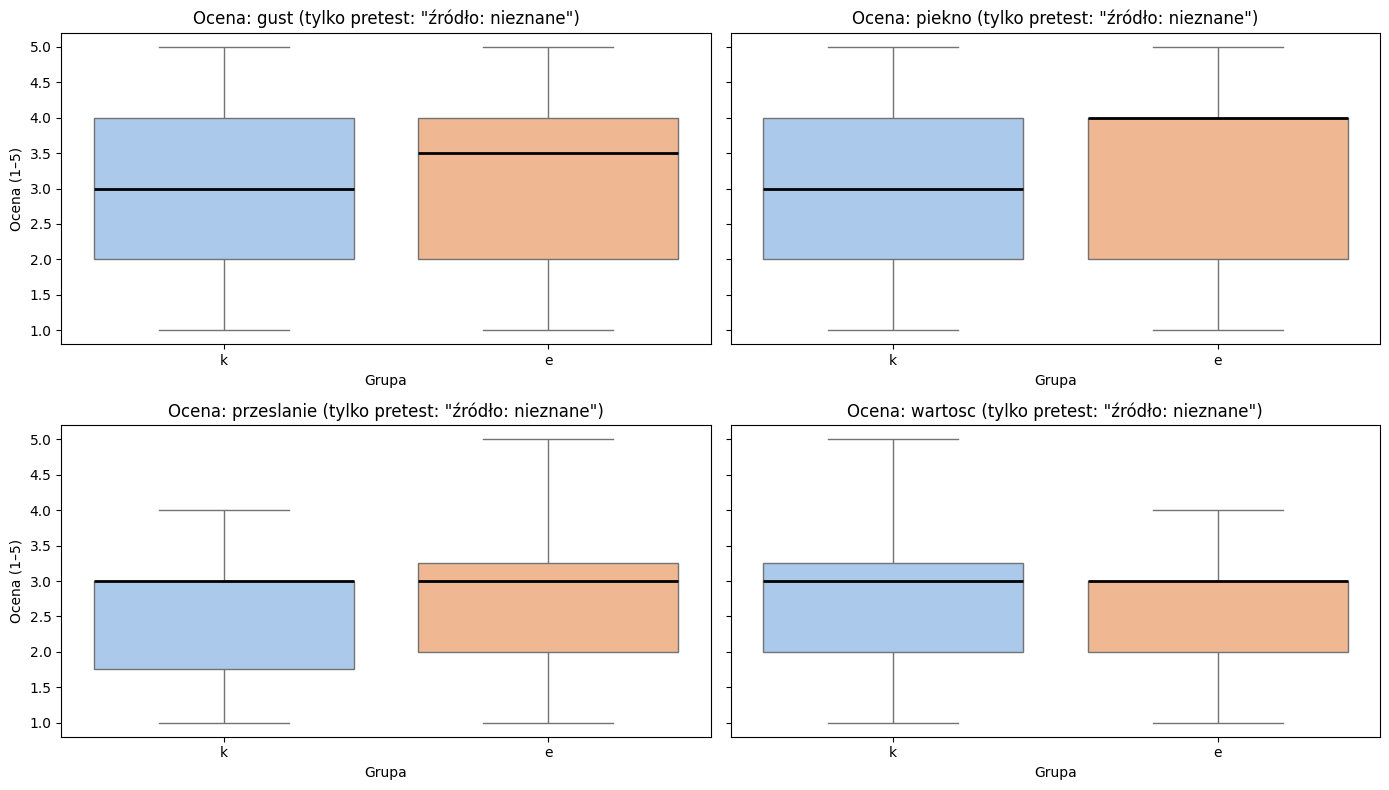

In [10]:
kategorie = ['gust', 'piekno', 'przeslanie', 'wartosc']

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.flatten()

for i, kat in enumerate(kategorie):
    ax = axes[i]
    sns.boxplot(
        data=df_pretest,
        x='grupa',
        y=kat,
        hue='grupa',
        legend=False,
        palette='pastel',
        ax=ax,
        medianprops={'linewidth': 2, 'color': 'black'}
    )
   
    ax.set_title(f'Ocena: {kat} (tylko pretest: "źródło: nieznane")')
    ax.set_ylabel('Ocena (1–5)')
    ax.set_xlabel('Grupa')

plt.tight_layout()
plt.show()

Wnioski:
- mediana w grupie kontrolnej jest taka sama dla wszystkich kategorii
- wykresy zdają się pokrywać - różnica może być mała

Zanim przeprowadzimy test statystyczny, sprawdzimy, czy rozkład danych jest normalny – pozwoli nam to dobrać odpowiedni test. W tym celu zastosujemy test Shapiro-Wilka.

### Test sprawdzający normalność rozkładu - Test Shapiro-Wilka

Test ten oceni, czy dane (dla danej grupy) mają rozkład zbliżony do normalnego.

Wiele testów statystycznych, takich jak test t-studenta czy ANOVA, zakłada normalność rozkładu. Jeśli dane nie spełniają tego założenia, lepszym wyborem mogą być testy nieparametryczne (np. Mann-Whitney'a).

Jak będziemy interpretować wyniki?
- p > 0,05: Brak istotnych różnic względem rozkładu normalnego – dane są zgodne z tym założeniem (można stosować test t itp.).
- p < 0,05: Dane istotnie odbiegają od rozkładu normalnego – warto rozważyć użycie testów nieparametrycznych.

In [32]:
for kat in kategorie:
    grupa_k = df_pretest[df_pretest['grupa'] == 'k'][kat]
    grupa_e = df_pretest[df_pretest['grupa'] == 'e'][kat]

    print(f"\n {kat.upper()}")

    s1 = shapiro(grupa_k)
    s2 = shapiro(grupa_e)

    print(f"  Shapiro kontrolna: p = {s1.pvalue:}")
    print(f"  Shapiro eksperymentalna: p = {s2.pvalue:} \n")

    #dobór testu (jeśli pvalue <0.005 - dane odbiegają od normalności), w przeciwnym wypadku - rozkład normalny (brak podstaw, aby odrzucić normalność)
    if s1.pvalue > 0.05 and s2.pvalue > 0.05:
        #normalny rozkład: t-test
        stat, p = ttest_ind(grupa_k, grupa_e)
        test = "t-test (niezależne)"
    else:
        #nie normalny - Mann-Whitney
        stat, p = mannwhitneyu(grupa_k, grupa_e, alternative='two-sided')
        test = "Mann-Whitney"

    print(f"  Test: {test}")
    print(f"  Statystyka: {stat:.3f}, p = {p:.4f}")


 GUST
  Shapiro kontrolna: p = 0.0009638757819843783
  Shapiro eksperymentalna: p = 0.00042488881619579086 

  Test: Mann-Whitney
  Statystyka: 1046.000, p = 0.4242

 PIEKNO
  Shapiro kontrolna: p = 0.0014282106199064038
  Shapiro eksperymentalna: p = 0.0004878968379340951 

  Test: Mann-Whitney
  Statystyka: 1089.500, p = 0.6397

 PRZESLANIE
  Shapiro kontrolna: p = 5.687217555353449e-05
  Shapiro eksperymentalna: p = 0.0008432714990659501 

  Test: Mann-Whitney
  Statystyka: 1001.000, p = 0.2525

 WARTOSC
  Shapiro kontrolna: p = 6.333216749131137e-05
  Shapiro eksperymentalna: p = 1.7389844095962095e-05 

  Test: Mann-Whitney
  Statystyka: 1033.500, p = 0.3605


Dane istotnie odbiegały od rozkładu normalnego, dlatego dla wszystkich kategorii zastosowano test Manna-Whitneya.

Wartości p dla każdego z testów były większe niż 0,05, co oznacza, że różnice między grupą eksperymentalną a kontrolną w ocenach poszczególnych kategorii (gust, piękno, przesłanie, wartość) nie były statystycznie istotne.

Można więc uznać, że pretest się powiódł – uczestnicy z obu grup oceniali obrazy „bez podpisów” w sposób zbliżony. Oznacza to, że grupy startują z porównywalnego poziomu, co pozwala rzetelnie analizować wpływ podpisów w kolejnych etapach badania.

### Porównanie poszczególnych obrazów w preteście

#### Wizualizacja

Przejdziemy teraz do bardziej szczegółowej wizualizacji – porównamy oceny poszczególnych obrazów w preteście między grupą eksperymentalną a kontrolną.

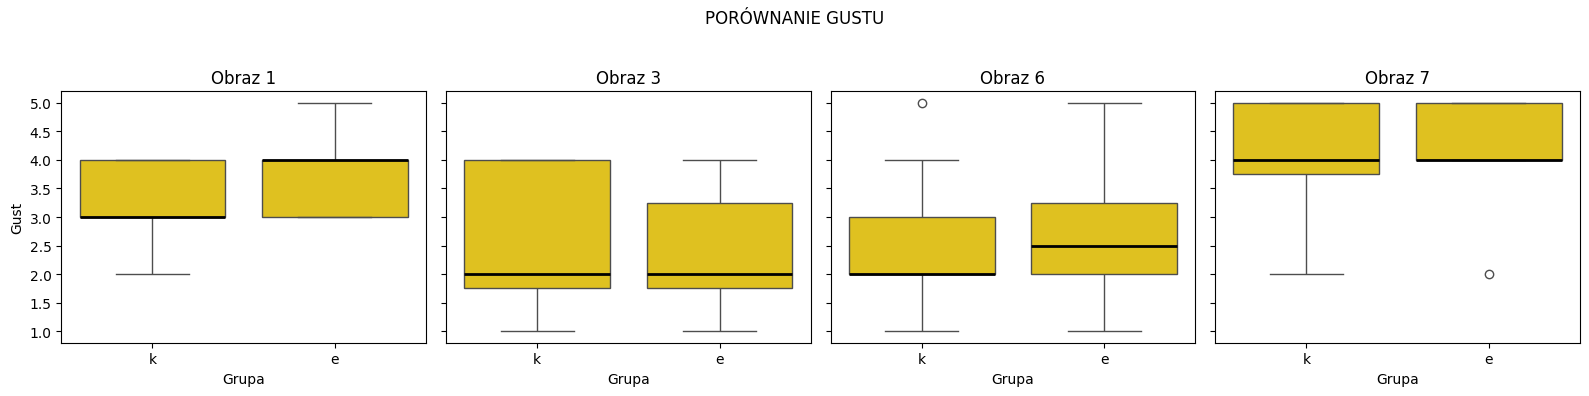

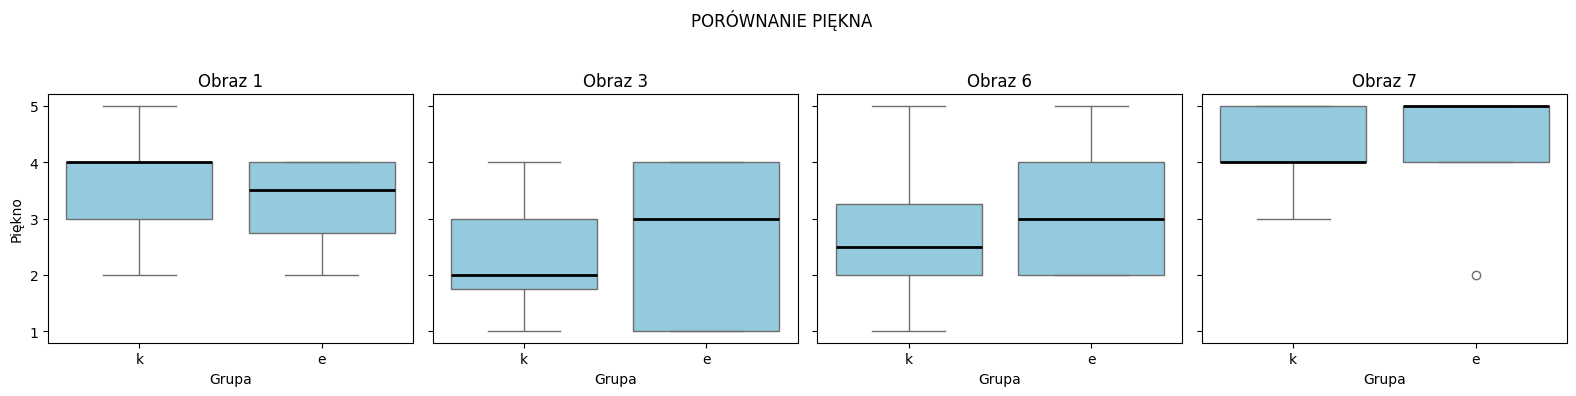

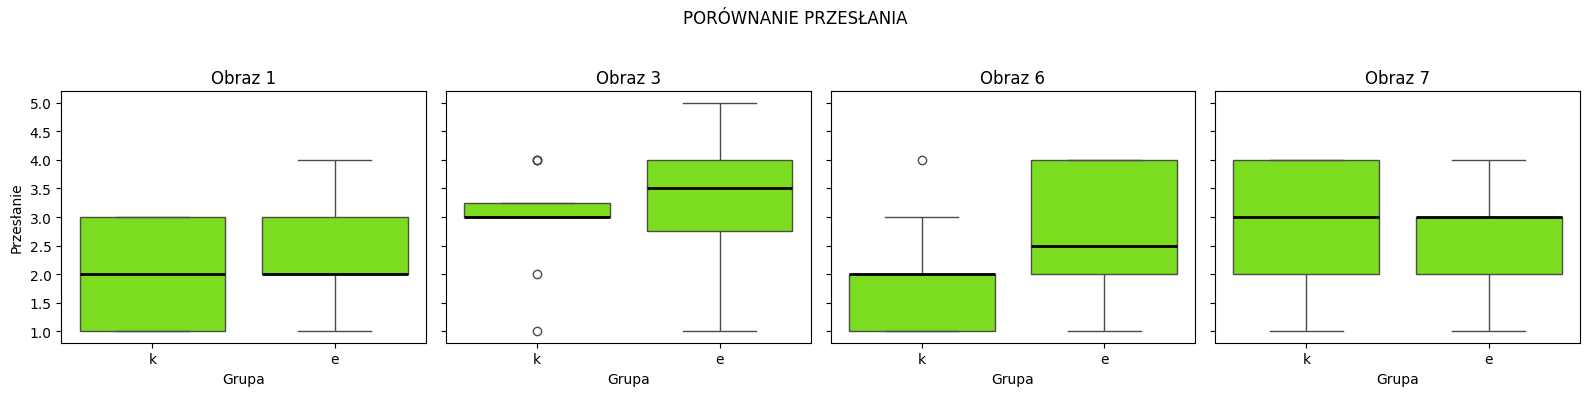

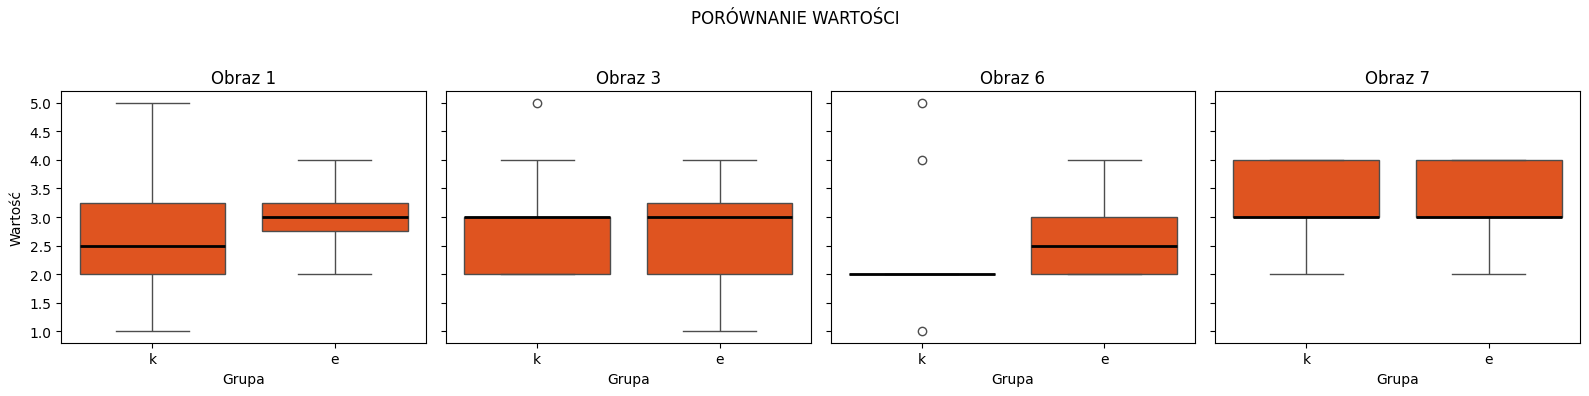

In [35]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

images = [1, 3, 6, 7]  #obrazy z pretestu
for i, img in enumerate(images):
    ax = axes[i]
    sns.boxplot(
        data=df_pretest[df_pretest['numer_obrazu'] == img],
        x='grupa', y='gust',
        ax=ax,
        color='gold',
        medianprops={'linewidth': 2, 'color': 'black'}
    )
    ax.set_title(f'Obraz {img}')
    ax.set_xlabel('Grupa')
    if i == 0:
        ax.set_ylabel('Gust')
    else:
        ax.set_ylabel('')

plt.suptitle('PORÓWNANIE GUSTU')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, img in enumerate(images):
    ax = axes[i]
    sns.boxplot(
        data=df_pretest[df_pretest['numer_obrazu'] == img],
        x='grupa', y='piekno',
        ax=ax,
        color='skyblue',
        medianprops={'linewidth': 2, 'color': 'black'}
    )
    ax.set_title(f'Obraz {img}')
    ax.set_xlabel('Grupa')
    if i == 0:
        ax.set_ylabel('Piękno')
    else:
        ax.set_ylabel('')

plt.suptitle('PORÓWNANIE PIĘKNA')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, img in enumerate(images):
    ax = axes[i]
    sns.boxplot(
        data=df_pretest[df_pretest['numer_obrazu'] == img],
        x='grupa', y='przeslanie',
        ax=ax,
        color='lawngreen',
        medianprops={'linewidth': 2, 'color': 'black'}
    )
    ax.set_title(f'Obraz {img}')
    ax.set_xlabel('Grupa')
    if i == 0:
        ax.set_ylabel('Przesłanie')
    else:
        ax.set_ylabel('')

plt.suptitle('PORÓWNANIE PRZESŁANIA')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, img in enumerate(images):
    ax = axes[i]
    sns.boxplot(
        data=long_df[long_df['numer_obrazu'] == img],
        x='grupa', y='wartosc',
        ax=ax,
        color='orangered',
        medianprops={'linewidth': 2, 'color': 'black'}
    )
    ax.set_title(f'Obraz {img}')
    ax.set_xlabel('Grupa')
    if i == 0:
        ax.set_ylabel('Wartość')
    else:
        ax.set_ylabel('')

plt.suptitle('PORÓWNANIE WARTOŚCI')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Wnioski:
- GUST: nie ma istotnej różnicy w rozkładzie ocen w obu grupach
- obraz 3 (PIĘKNO) - większy rozrzut, może spowodowane tym, że wprowadzony wcześniej został orbaz inny niż "nieznany"
- mediany są na zbliżonych poziomach
- rozrzuty często się pokrywają (z wyjątkiem obrazu 6 PRZESŁANIE)

Zobaczmy, co na ten temat mówią wyniki analizy statystycznej.

####  Test statystyczny

In [39]:
for img in images:  # POSTTEST paintings
    #test Mann-Whitney
    print(f"\n --- Obraz {img} ---")
    for kat in kategorie:
        ctrl = df_pretest[(df_pretest['grupa'] == 'k') & (df_pretest['numer_obrazu'] == img)][kat].dropna().astype(float)
        exp = df_pretest[(df_pretest['grupa'] == 'e') & (df_pretest['numer_obrazu'] == img)][kat].dropna().astype(float)

        stat, p = mannwhitneyu(ctrl, exp)

        print(f"{kat.upper()}: p = {p:.4f}")


 --- Obraz 1 ---
GUST: p = 0.2292
PIEKNO: p = 0.4148
PRZESLANIE: p = 0.7604
WARTOSC: p = 0.4295

 --- Obraz 3 ---
GUST: p = 0.9043
PIEKNO: p = 0.6332
PRZESLANIE: p = 0.4626
WARTOSC: p = 1.0000

 --- Obraz 6 ---
GUST: p = 0.7414
PIEKNO: p = 0.5244
PRZESLANIE: p = 0.0747
WARTOSC: p = 0.1608

 --- Obraz 7 ---
GUST: p = 0.6587
PIEKNO: p = 0.4451
PRZESLANIE: p = 0.5599
WARTOSC: p = 0.9492


Wnioski:
- Dla wszystkich obrazów i wszystkich ocen (gust, piękno, przesłanie, wartość) wartości p są większe niż 0,05 (np. 0,2292; 0,4148; 0,7604 itd.).
- Nie ma statystycznie istotnych różnic między grupą eksperymentalną a kontrolną w ocenach tych obrazów podczas pretestu.
- Grupy reagowały podobnie, co sugeruje, że były porównywalne przed wprowadzeniem ewentualnej manipulacji.

## Porównanie posttestu

sprawdzimy, czy podpisy wpływają na poszczególne kategorie pomiędzy grupami kontrolną i eksperymentalną

Zaczniemy jednak od przygotowania danych:

In [40]:
# list obrazów, które są eksperymentalne - zebysmy mogly porownywac tylko te same
obrazy_posttest = [2,4,5,8]

df_e = long_df[long_df['grupa'] == 'e']
posttest_e = df_e[df_e['numer_obrazu'].isin(obrazy_posttest)]

df_k = long_df[long_df['grupa'] == 'k']
posttest_k = df_k[df_k['numer_obrazu'].isin(obrazy_posttest)]

posttest_all = pd.concat([posttest_e, posttest_k], ignore_index=True) #łączymy tak, żeby mieć 1 dataframe

Policzmy średnią ocen w obu grupach dla każdego z obrazów

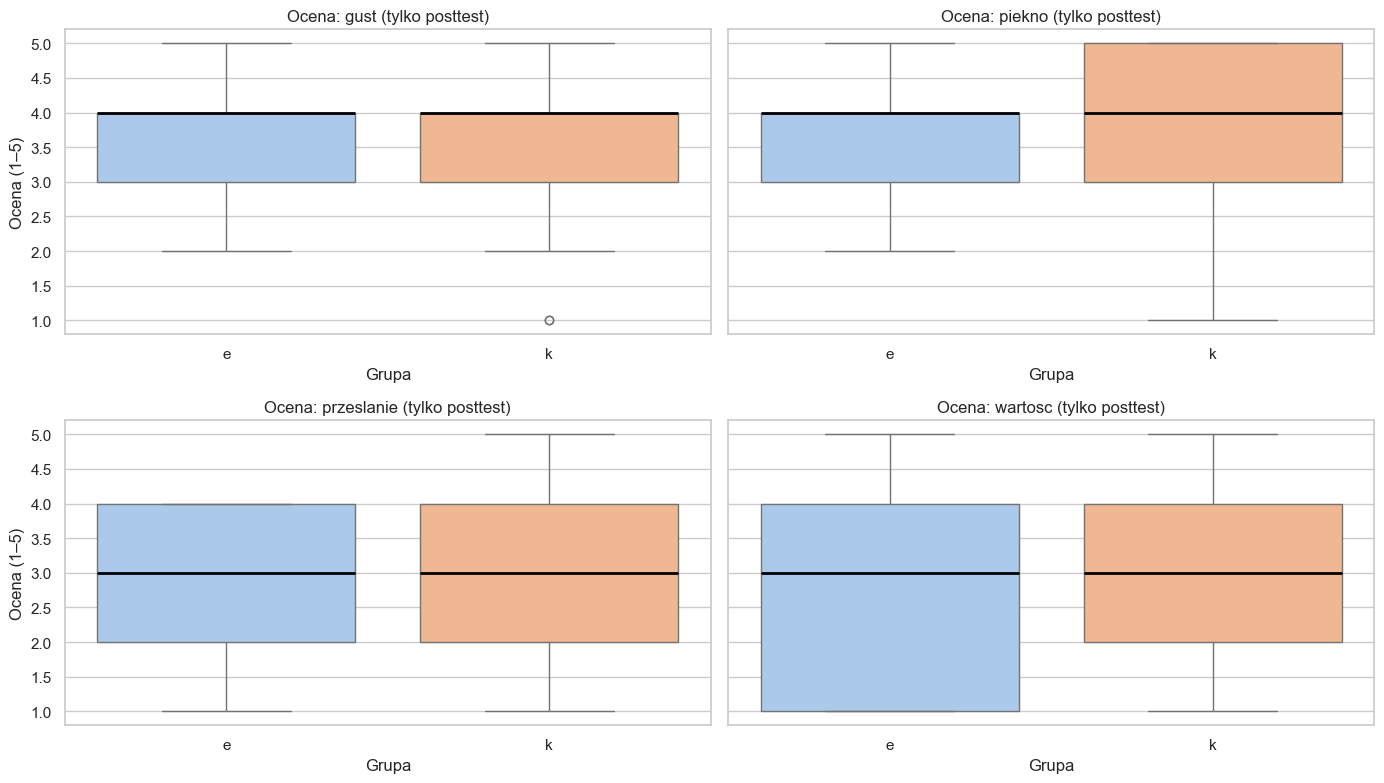

In [45]:
kategorie = ['gust', 'piekno', 'przeslanie', 'wartosc']

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.flatten()

for i, kat in enumerate(kategorie):
    ax = axes[i]
    sns.boxplot(
        data=posttest_all,
        x='grupa',
        y=kat,
        hue='grupa',
        legend=False,
        palette='pastel',
        ax=ax,
        medianprops={'linewidth': 2, 'color': 'black'}
    )
   
    ax.set_title(f'Ocena: {kat} (tylko posttest)')
    ax.set_ylabel('Ocena (1–5)')
    ax.set_xlabel('Grupa')

plt.tight_layout()
plt.show()

Zrobimy znowu test statystyczny.

In [46]:
for kat in kategorie:
    grupa_k = posttest_all[posttest_all['grupa'] == 'k'][kat]
    grupa_e = posttest_all[posttest_all['grupa'] == 'e'][kat]

    print(f"\n {kat.upper()}")

    s1 = shapiro(grupa_k)
    s2 = shapiro(grupa_e)

    print(f"  Shapiro kontrolna: p = {s1.pvalue:}")
    print(f"  Shapiro eksperymentalna: p = {s2.pvalue:} \n")

    #dobór testu (jeśli pvalue <0.005 - dane odbiegają od normalności), w przeciwnym wypadku - rozkład normalny (brak podstaw, aby odrzucić normalność)
    if s1.pvalue > 0.05 and s2.pvalue > 0.05:
        #normalny rozkład: t-test
        stat, p = ttest_ind(grupa_k, grupa_e)
        test = "t-test"
    else:
        #nie normalny - Mann-Whitney
        stat, p = mannwhitneyu(grupa_k, grupa_e, alternative='two-sided')
        test = "Mann-Whitney"

    print(f"  Test: {test}")
    print(f"  Statystyka: {stat:.3f}, p = {p:.4f}")


 GUST
  Shapiro kontrolna: p = 0.0005236611150729831
  Shapiro eksperymentalna: p = 3.212882463035582e-05 

  Test: Mann-Whitney
  Statystyka: 1055.000, p = 0.4576

 PIEKNO
  Shapiro kontrolna: p = 2.0552855143292087e-05
  Shapiro eksperymentalna: p = 2.025533664741809e-05 

  Test: Mann-Whitney
  Statystyka: 1253.500, p = 0.4264

 PRZESLANIE
  Shapiro kontrolna: p = 0.00017635694025988679
  Shapiro eksperymentalna: p = 1.4488398094125296e-05 

  Test: Mann-Whitney
  Statystyka: 1204.000, p = 0.6964

 WARTOSC
  Shapiro kontrolna: p = 0.000882727415759167
  Shapiro eksperymentalna: p = 0.0001949900241191322 

  Test: Mann-Whitney
  Statystyka: 1297.000, p = 0.2749


Dane istotnie odbiegały od rozkładu normalnego, dlatego dla wszystkich kategorii zastosowano test Manna-Whitneya.

Wartości p dla każdego z testów były większe niż 0.05, co oznacza, że różnice między grupą eksperymentalną a kontrolną w ocenach poszczególnych kategorii (gust, piękno, przesłanie, wartość) nie były statystycznie istotne.

### Porównanie poszczególnych obrazów w postteście

#### Wizualizacja

##### boxplot

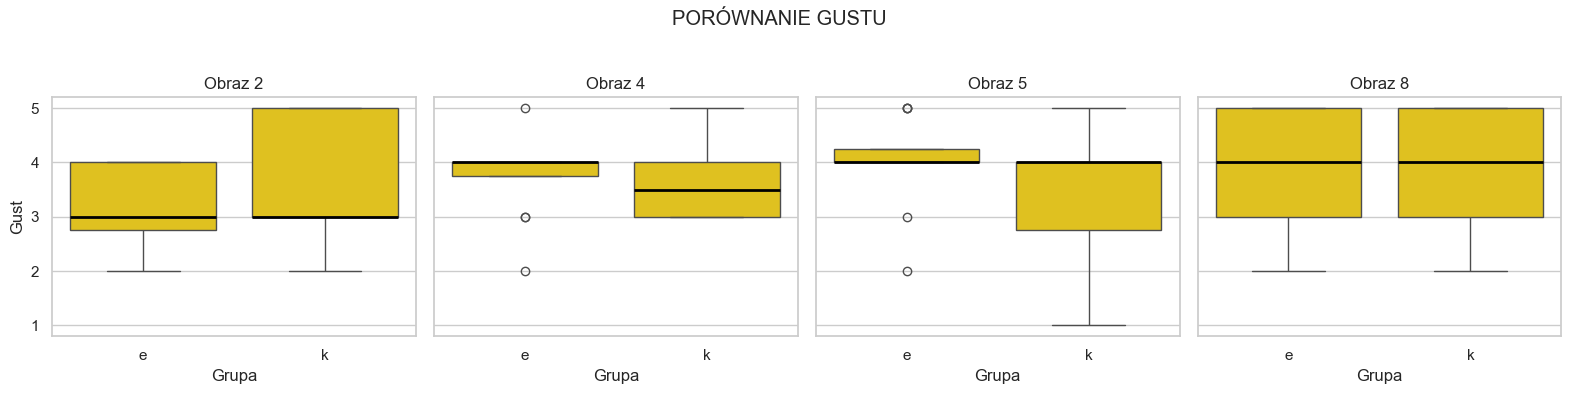

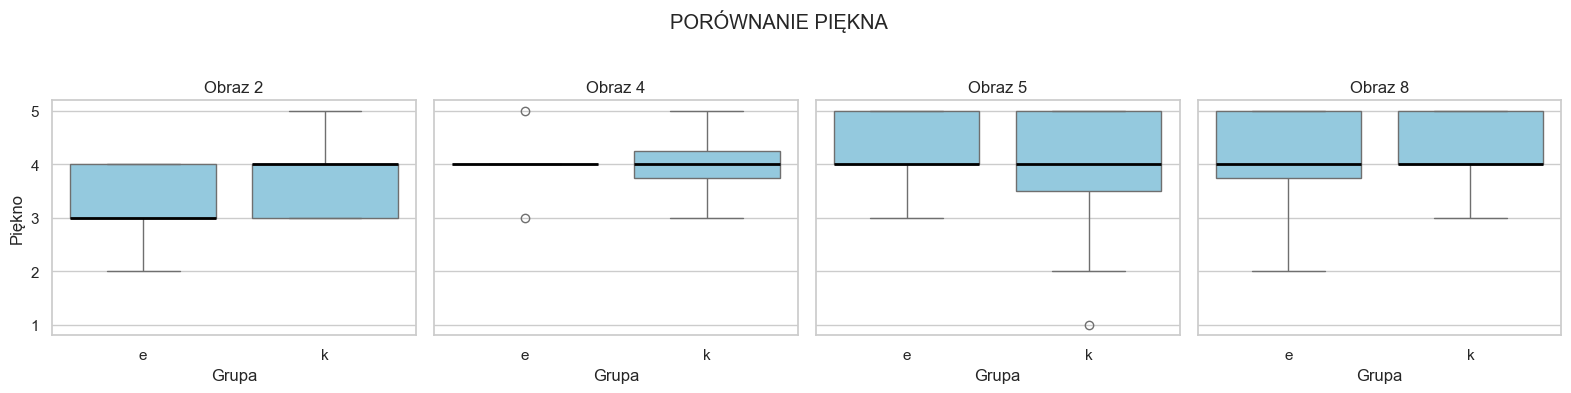

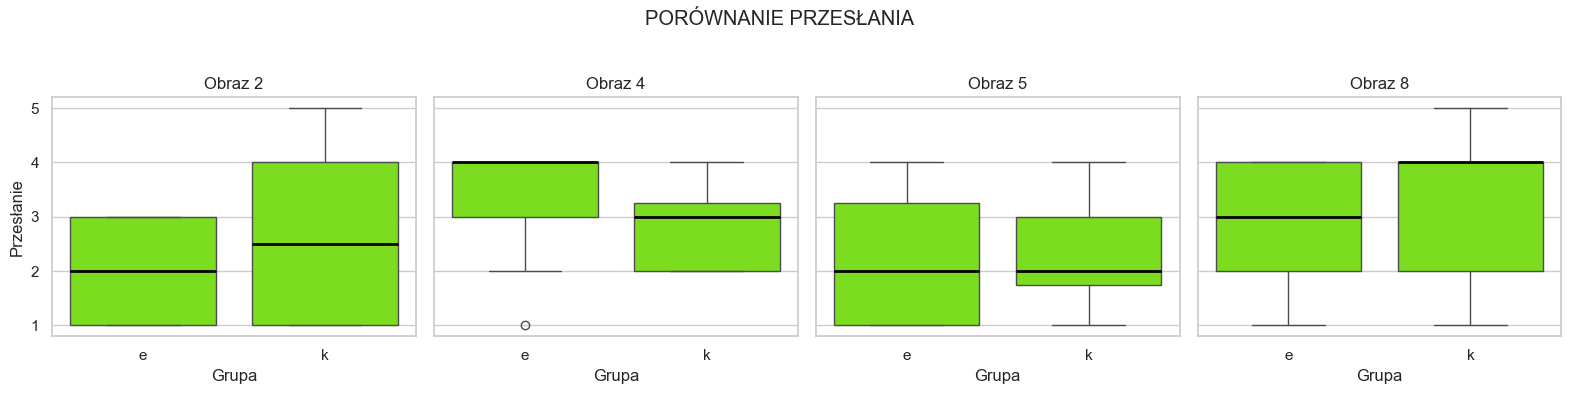

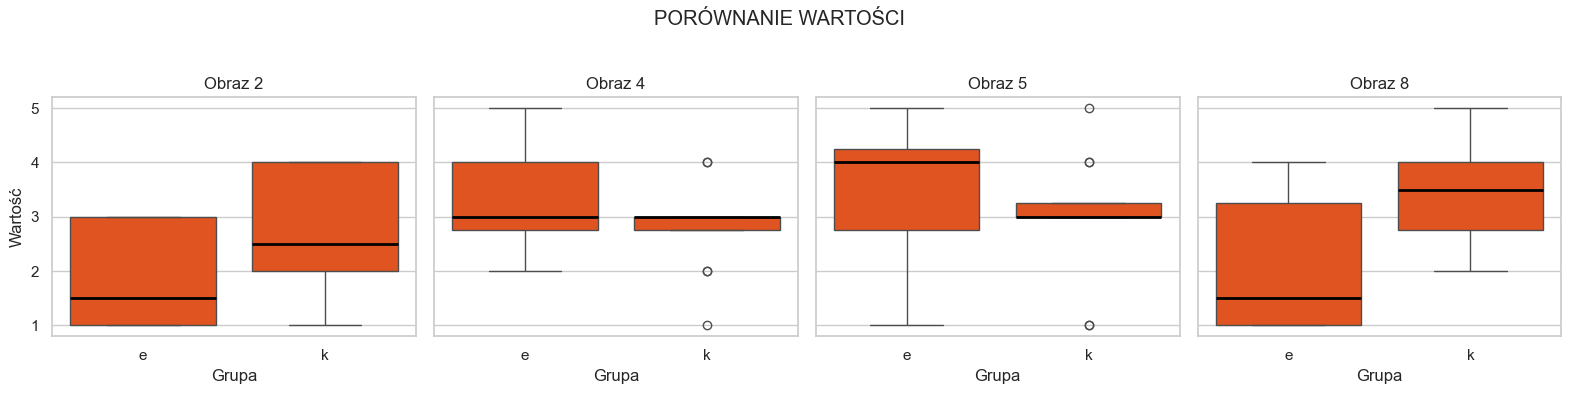

In [48]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, img in enumerate(obrazy_posttest):
    ax = axes[i]
    sns.boxplot(
        data=posttest_all[posttest_all['numer_obrazu'] == img],
        x='grupa', y='gust',
        ax=ax,
        color='gold',
        medianprops={'linewidth': 2, 'color': 'black'}
    )
    ax.set_title(f'Obraz {img}')
    ax.set_xlabel('Grupa')
    if i == 0:
        ax.set_ylabel('Gust')
    else:
        ax.set_ylabel('')

plt.suptitle('PORÓWNANIE GUSTU')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, img in enumerate(obrazy_posttest):
    ax = axes[i]
    sns.boxplot(
        data=posttest_all[posttest_all['numer_obrazu'] == img],
        x='grupa', y='piekno',
        ax=ax,
        color='skyblue',
        medianprops={'linewidth': 2, 'color': 'black'}
    )
    ax.set_title(f'Obraz {img}')
    ax.set_xlabel('Grupa')
    if i == 0:
        ax.set_ylabel('Piękno')
    else:
        ax.set_ylabel('')

plt.suptitle('PORÓWNANIE PIĘKNA')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, img in enumerate(obrazy_posttest):
    ax = axes[i]
    sns.boxplot(
        data=posttest_all[posttest_all['numer_obrazu'] == img],
        x='grupa', y='przeslanie',
        ax=ax,
        color='lawngreen',
        medianprops={'linewidth': 2, 'color': 'black'}
    )
    ax.set_title(f'Obraz {img}')
    ax.set_xlabel('Grupa')
    if i == 0:
        ax.set_ylabel('Przesłanie')
    else:
        ax.set_ylabel('')

plt.suptitle('PORÓWNANIE PRZESŁANIA')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, img in enumerate(obrazy_posttest):
    ax = axes[i]
    sns.boxplot(
        data=posttest_all[posttest_all['numer_obrazu'] == img],
        x='grupa', y='wartosc',
        ax=ax,
        color='orangered',
        medianprops={'linewidth': 2, 'color': 'black'}
    )
    ax.set_title(f'Obraz {img}')
    ax.set_xlabel('Grupa')
    if i == 0:
        ax.set_ylabel('Wartość')
    else:
        ax.set_ylabel('')

plt.suptitle('PORÓWNANIE WARTOŚCI')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




Wnioski
- w obrazie 2. (p_AI - a_ludzki) są niewielkie rozbieżności; w każdej z kategorii grupa eksperymentalna niżej oceniała ten obraz
- w obrazie 4. (p_ludzki - a_ludzki) oceny gustu i piękna są na podobnym poziomie, natomiast widać wyraźny wzrost ocen dla przesłania i wartości w grupie eksperymentalnej
- w obrazie 5. (p_ludzki - a_AI) mamy zawyżoną ocenę gustu i wartości (obraz podpisany jako ludzki)
- w obrazie 8. (p_AI - a_AI) były zaniżone wartości dla grupy eksperymentalnej (obraz podpisany jako AI)

##### Wykres kolumnowy - średnie ocen

Spójrzmy teraz na średnie ocen dla każdego z obrazów

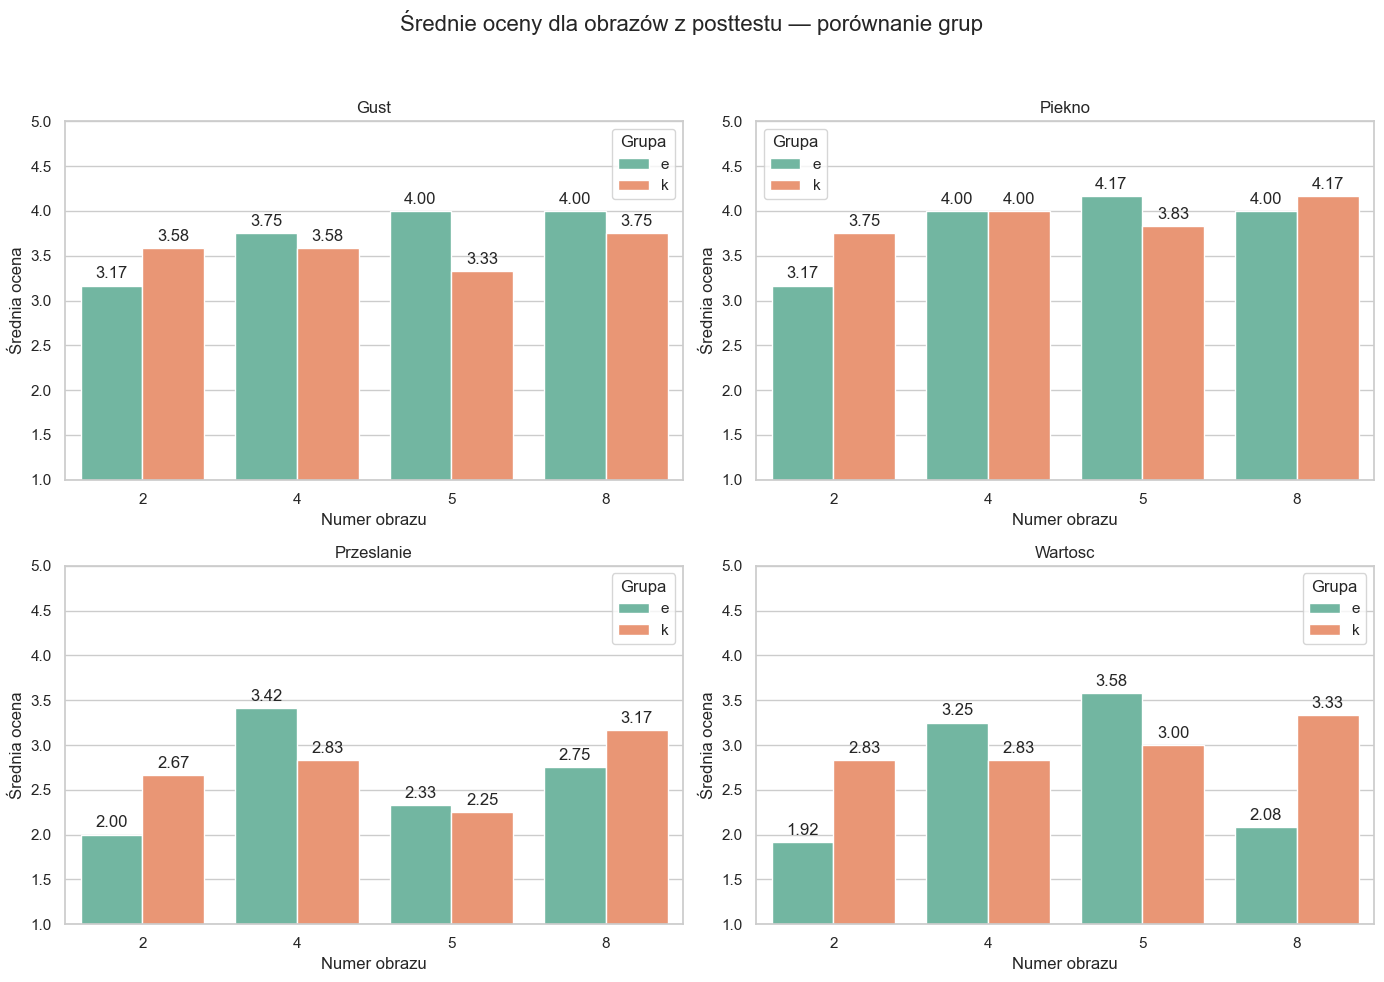

In [54]:
# Ustawienia stylu
sns.set(style="whitegrid")

# Tworzymy siatkę 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Średnie oceny dla obrazów z posttestu — porównanie grup", fontsize=16)

axes = axes.flatten()



# Rysowanie wykresów
for i, kat in enumerate(kategorie):
    ax = axes[i]

    # Tworzymy wykres
    sns.barplot(
        data=posttest_all,
        x='numer_obrazu',
        y=kat,
        hue='grupa',
        errorbar=None,
        palette='Set2',
        ax=ax
    )

   # Dodanie wartości nad słupkami
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)
        
    # Opis wykresu
    ax.set_title(kat.capitalize())
    ax.set_xlabel("Numer obrazu")
    ax.set_ylabel("Średnia ocena")
    ax.set_ylim(1, 5)
    ax.legend(title="Grupa")



# Dopasowanie i pokazanie
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Wnioski:
- obraz 2. (p_AI - a_ludzki) był oceniany srednio niżej w grupie eksperymentalnej (podpisany był jako AI)
- obraz 4. (p_ludzki - a_ludzki) - mamy tu zdecydowanie wyższe przesłanie i wartość. Piękno zostało ocenione podobnie, gust nieznacznie wyżej w przypadku grupy eksperymentalnej
- obraz 5. (p_ludzki - a_AI) - został oceniony znacznie wyżej w kategorii gustu oraz wartości, nieznanie wyżej w kwestii piękna i podobnie w kwestii przesłanie
- obraz 8. (p_AI - a_AI) - został oceniony nieznacznie lepiej w kwestii gustu, a nieznacznie gorzej w kwestii piękna przez grupę eksperymentalną. Przesłanie ocenione było nieznacznie gorzej, natomiast wyraźną różnicę widać w ocenie wartości - przeskok aż o 1.

#### Test statystyczny

Znowu szukamy potwierdzenia w liczbach. ponieważ nie ma normalnych danych, to użyjemy sobie testu Mann-Whitney U do porównania rozkładów ocen w obu grupach dla każdego obrazu (ten test nie inny, bo są tylko 2 grupy, więc będzie optymalnie)

In [55]:
for kat in kategorie:
    print(kat.upper())
    for obraz in obrazy_posttest:
        e_oceny = posttest_e[posttest_e['numer_obrazu'] == obraz][kat]
        k_oceny = posttest_k[posttest_k['numer_obrazu'] == obraz][kat]

        # Test Mann-Whitney U
        stat, p = mannwhitneyu(e_oceny, k_oceny)

        print(f'Porównanie dla obrazu {obraz}, {mapa_podpisow[obraz]}: p = {p}')

    print("\n")

GUST
Porównanie dla obrazu 2, fałszywe_ludzkie: p = 0.433807406041108
Porównanie dla obrazu 4, prawdziwe_ludzkie: p = 0.40278974535653544
Porównanie dla obrazu 5, fałszywe_AI: p = 0.18478822989107546
Porównanie dla obrazu 8, prawdziwe_AI: p = 0.6080540429156747


PIEKNO
Porównanie dla obrazu 2, fałszywe_ludzkie: p = 0.09727255172829653
Porównanie dla obrazu 4, prawdziwe_ludzkie: p = 1.0
Porównanie dla obrazu 5, fałszywe_AI: p = 0.9262447717403842
Porównanie dla obrazu 8, prawdziwe_AI: p = 0.7797898333709593


PRZESLANIE
Porównanie dla obrazu 2, fałszywe_ludzkie: p = 0.2961287934239367
Porównanie dla obrazu 4, prawdziwe_ludzkie: p = 0.08376043703141925
Porównanie dla obrazu 5, fałszywe_AI: p = 0.9521597895400402
Porównanie dla obrazu 8, prawdziwe_AI: p = 0.36419115531978496


WARTOSC
Porównanie dla obrazu 2, fałszywe_ludzkie: p = 0.05250895338634007
Porównanie dla obrazu 4, prawdziwe_ludzkie: p = 0.34022363135602063
Porównanie dla obrazu 5, fałszywe_AI: p = 0.17857535460932017
Porównani

Wnioski:
- Brak istotnych różnic między grupami w ocenie gustu dla żadnego z obrazów
- Brak istotnych różnic, choć dla obrazu 2 warto obserwować trend (blisko progu, ale nieistotne)
- Brak istotnych różnic, choć obraz 4 może sugerować subtelne różnice
- Tylko dla obrazu 8 (prawdziwe_AI) grupy różniły się istotnie w ocenie wartości

Pozostałe oceny nie wykazały istotnych różnic, choć niektóre zbliżają się do granicy.

Mimo że naocznie byłyśmy w stanie stwierdzić pewne różnice, to testy statystyczne nie wykazały istotności tych różnic.
Może to być spowodowane zbyt małą próbą. Generalnie,

Sprawdzimy jeszcze siłę ekfetu tego testu.

In [58]:
# Approximate Z from U statistic
n1 = len(e_oceny)
n2 = len(k_oceny)
U = stat
mu_U = n1 * n2 / 2
sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z = (U - mu_U) / sigma_U

# Siła efektu
r = z / np.sqrt(n1 + n2)

print(f"Z = {z:.3f}")
print(f"Siła efektu r = {r:.3f}")

Z = -2.252
Siła efektu r = -0.460


Pomijając znak (bo znak wskazuje tylko kierunek efektu, nie jego siłę):
|r| = 0.460 → to jest średnio-duży efekt.

Brak istotności statystycznej oznacza, że na podstawie danych nie mamy wystarczających dowodów, by stwierdzić, że różnice między grupami są realne (czyli mogły wyniknąć z przypadku).

**Mimo to umiarkowana/duża siła efektu sugeruje, że różnice mogą być praktycznie ważne lub że próbka jest zbyt mała, aby wykryć tę różnicę z odpowiednią mocą statystyczną.**

### Wpływ czynników indywidualnych na percepcję

Sprawdzimy zaleźność ocen od danych z metryczki

In [61]:
# model regresji wielorakiej - wpływ na gust
model = smf.ols('gust ~ plec + znajomosc_sztuki + miejsce_zamieszkania + sytuacja_materialna + grupa', data=posttest_all).fit()

# wyniki
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   gust   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.7200
Date:                Thu, 29 May 2025   Prob (F-statistic):              0.703
Time:                        17:34:00   Log-Likelihood:                -131.28
No. Observations:                  96   AIC:                             284.6
Df Residuals:                      85   BIC:                             312.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

Wnioski:
- R-squared: 0.078. Współczynnik determinacji, mówi, że model wyjaśnia tylko 7,8% wariancji zmiennej „gust”. To dosyć niska wartość — model słabo tłumaczy zmienność „gustu”.
- Żaden z badanych predyktorów nie ma istotnego wpływu (wszystkie p > 0.05)


In [62]:
# model regresji wielorakiej - wpływ na piekno
model = smf.ols('piekno ~ plec + znajomosc_sztuki + miejsce_zamieszkania + sytuacja_materialna + grupa', data=posttest_all).fit()

# wyniki
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 piekno   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.385
Date:                Thu, 29 May 2025   Prob (F-statistic):              0.201
Time:                        17:39:24   Log-Likelihood:                -114.99
No. Observations:                  96   AIC:                             252.0
Df Residuals:                      85   BIC:                             280.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

Żadne z badanych zmiennych nie ma istotnego wpływu na ocenę piękna (wszystkie p > 0.05).

In [64]:
# model regresji wielorakiej - wpływ na przeslanie
model = smf.ols('przeslanie ~ plec + znajomosc_sztuki + miejsce_zamieszkania + sytuacja_materialna + grupa', data=posttest_all).fit()

# wyniki
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             przeslanie   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.6799
Date:                Thu, 29 May 2025   Prob (F-statistic):              0.740
Time:                        17:41:39   Log-Likelihood:                -148.17
No. Observations:                  96   AIC:                             318.3
Df Residuals:                      85   BIC:                             346.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

Żadna z badanych cech (płeć, znajomość sztuki, miejsce zamieszkania, grupa, sytuacja materialna) nie ma statystycznie istotnego wpływu na ocenę przesłania.

In [65]:
# model regresji wielorakiej - wpływ na wartosc
model = smf.ols('wartosc ~ plec + znajomosc_sztuki + miejsce_zamieszkania + sytuacja_materialna + grupa', data=posttest_all).fit()

# wyniki
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                wartosc   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.072
Date:                Thu, 29 May 2025   Prob (F-statistic):              0.392
Time:                        17:42:03   Log-Likelihood:                -146.51
No. Observations:                  96   AIC:                             315.0
Df Residuals:                      85   BIC:                             343.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

Wyniki sugerują, że obecne zmienne nie tłumaczą różnic w ocenie wartości w danych

Wyniki wskazują, że żadna z badanych zmiennych (płeć, znajomość sztuki, miejsce zamieszkania, grupa, sytuacja materialna) nie miała statystycznie istotnego wpływu na ocenę wartości obrazów. Były to zmienne uboczne kontrolowane i nie wykazano ich znaczącego oddziaływania na wyniki ocen.